In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Path to your GloVe pre-trained embeddings file
glove_file_path = 'glove.6B.300d.txt'

# Load GloVe embeddings
model = load_glove_model(glove_file_path)

Loading Glove Model
400000 words loaded!


In [4]:
word_embedding = model.get('hello')
print(word_embedding)

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [5]:

def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            # Check if word exists in the model's vocabulary
            if word in model:
                embedding.append(model[word])
            else:
                # If word not found, use zero vector
                embedding.append([0] * model["hello"].size)
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 70  # maximum length of word in a text
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * model["hello"].size] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    # Filter out None values
    padded_embeddings = [embedding for embedding in padded_embeddings if embedding is not None]

    # Convert to tensor
    input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_50365/601243325.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)


In [7]:
x_train.size()

torch.Size([8019, 70, 300])

In [8]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [9]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [10]:
y_train.size()

torch.Size([8019, 70])

In [11]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUTagger, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = GRUTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_50365/3909336609.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_50365/3909336609.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_50365/3909336609.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_50365/3909336609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/130, Train Loss: 1.231437255465795, Val Loss: 0.9043072462081909, Val F1: 0.040684564414234244, Train F1: 0.03652354653934742


  2%|▋                                          | 2/130 [00:05<06:20,  2.97s/it]

Epoch 2/130, Train Loss: 0.8522928716644408, Val Loss: 0.7884743809700012, Val F1: 0.053157237261149834, Train F1: 0.049807579965257


  2%|▉                                          | 3/130 [00:08<06:16,  2.97s/it]

Epoch 3/130, Train Loss: 0.7461975784528823, Val Loss: 0.6960731744766235, Val F1: 0.11120228458335095, Train F1: 0.07850724111146548


  3%|█▎                                         | 4/130 [00:11<06:10,  2.94s/it]

Epoch 4/130, Train Loss: 0.6700166558462476, Val Loss: 0.6332331299781799, Val F1: 0.1295196377952428, Train F1: 0.12451706260292031


  4%|█▋                                         | 5/130 [00:14<06:05,  2.93s/it]

Epoch 5/130, Train Loss: 0.618051667062063, Val Loss: 0.5921667814254761, Val F1: 0.1495417530225447, Train F1: 0.14533082621527493


  5%|█▉                                         | 6/130 [00:17<06:02,  2.92s/it]

Epoch 6/130, Train Loss: 0.5829912267980122, Val Loss: 0.5631147623062134, Val F1: 0.16856260389658542, Train F1: 0.16438447278775706


  5%|██▎                                        | 7/130 [00:20<05:58,  2.92s/it]

Epoch 7/130, Train Loss: 0.5547626349661086, Val Loss: 0.5427761673927307, Val F1: 0.18852756568952825, Train F1: 0.18048448873766554


  6%|██▋                                        | 8/130 [00:23<05:55,  2.91s/it]

Epoch 8/130, Train Loss: 0.5324543402308509, Val Loss: 0.523155927658081, Val F1: 0.19722001200398928, Train F1: 0.19299521391741514


  7%|██▉                                        | 9/130 [00:26<05:52,  2.91s/it]

Epoch 9/130, Train Loss: 0.5132785278653341, Val Loss: 0.508221447467804, Val F1: 0.20649327110340668, Train F1: 0.2042419713310682


  8%|███▏                                      | 10/130 [00:29<05:48,  2.90s/it]

Epoch 10/130, Train Loss: 0.4983865140922486, Val Loss: 0.49812430143356323, Val F1: 0.2014491619841785, Train F1: 0.21218536281278852


  8%|███▌                                      | 11/130 [00:32<05:45,  2.90s/it]

Epoch 11/130, Train Loss: 0.48594339120955693, Val Loss: 0.4893767237663269, Val F1: 0.21398178237907145, Train F1: 0.21793572219556068


  9%|███▉                                      | 12/130 [00:35<05:45,  2.92s/it]

Epoch 12/130, Train Loss: 0.4765565778527941, Val Loss: 0.48352372646331787, Val F1: 0.21478443167068825, Train F1: 0.22686056413297248


 10%|████▏                                     | 13/130 [00:38<05:41,  2.92s/it]

Epoch 13/130, Train Loss: 0.46748785698224626, Val Loss: 0.47887465357780457, Val F1: 0.2259721126015629, Train F1: 0.23346647206811952


 11%|████▌                                     | 14/130 [00:40<05:37,  2.91s/it]

Epoch 14/130, Train Loss: 0.4592868960092938, Val Loss: 0.4752464294433594, Val F1: 0.2380215964409763, Train F1: 0.23849448761273526


 12%|████▊                                     | 15/130 [00:43<05:34,  2.91s/it]

Epoch 15/130, Train Loss: 0.45160390554912505, Val Loss: 0.4720822870731354, Val F1: 0.2295295716491259, Train F1: 0.24696443206060326


 12%|█████▏                                    | 16/130 [00:46<05:31,  2.91s/it]

Epoch 16/130, Train Loss: 0.44556345021913923, Val Loss: 0.469694584608078, Val F1: 0.23691937939536659, Train F1: 0.2530216223578875


 13%|█████▍                                    | 17/130 [00:49<05:29,  2.91s/it]

Epoch 17/130, Train Loss: 0.4381484876549433, Val Loss: 0.47029900550842285, Val F1: 0.2274428947853645, Train F1: 0.25637201512058855


 14%|█████▊                                    | 18/130 [00:52<05:25,  2.91s/it]

Epoch 18/130, Train Loss: 0.4313968136197045, Val Loss: 0.4699530303478241, Val F1: 0.22913149246324174, Train F1: 0.26705585079915145


 15%|██████▏                                   | 19/130 [00:55<05:22,  2.91s/it]

Epoch 19/130, Train Loss: 0.42705188667963423, Val Loss: 0.4662056863307953, Val F1: 0.254413781298287, Train F1: 0.2708259077347127


 15%|██████▍                                   | 20/130 [00:58<05:19,  2.91s/it]

Epoch 20/130, Train Loss: 0.4216565541804783, Val Loss: 0.4663093388080597, Val F1: 0.25154712440539523, Train F1: 0.273157969361251


 16%|██████▊                                   | 21/130 [01:01<05:16,  2.91s/it]

Epoch 21/130, Train Loss: 0.4145319296254052, Val Loss: 0.4667279124259949, Val F1: 0.269168590161256, Train F1: 0.28279506189988773


 17%|███████                                   | 22/130 [01:04<05:13,  2.91s/it]

Epoch 22/130, Train Loss: 0.40960588672804454, Val Loss: 0.46730247139930725, Val F1: 0.24757362676545316, Train F1: 0.28810383233510817


 18%|███████▍                                  | 23/130 [01:07<05:12,  2.92s/it]

Epoch 23/130, Train Loss: 0.40385712186495465, Val Loss: 0.4689081013202667, Val F1: 0.2642226011524296, Train F1: 0.2940784365237077


 18%|███████▊                                  | 24/130 [01:10<05:09,  2.92s/it]

Epoch 24/130, Train Loss: 0.3987565291306329, Val Loss: 0.4703308343887329, Val F1: 0.2508878537004699, Train F1: 0.29822589446229825


 19%|████████                                  | 25/130 [01:12<05:07,  2.92s/it]

Epoch 25/130, Train Loss: 0.3922809518518902, Val Loss: 0.4708500802516937, Val F1: 0.27156481445416225, Train F1: 0.3075986103057285


 20%|████████▍                                 | 26/130 [01:15<05:03,  2.92s/it]

Epoch 26/130, Train Loss: 0.3870435489548577, Val Loss: 0.4738653004169464, Val F1: 0.265229212081751, Train F1: 0.31410295343570943


 21%|████████▋                                 | 27/130 [01:18<05:00,  2.92s/it]

Epoch 27/130, Train Loss: 0.38070405759508646, Val Loss: 0.4805195927619934, Val F1: 0.2462265440112171, Train F1: 0.3222687584580821


 22%|█████████                                 | 28/130 [01:21<05:00,  2.95s/it]

Epoch 28/130, Train Loss: 0.3763351875638205, Val Loss: 0.4785115718841553, Val F1: 0.2799850628685862, Train F1: 0.3273715051552312


 22%|█████████▎                                | 29/130 [01:24<04:56,  2.93s/it]

Epoch 29/130, Train Loss: 0.3695631443508088, Val Loss: 0.4871412515640259, Val F1: 0.2639675553014284, Train F1: 0.33263742561168413


 23%|█████████▋                                | 30/130 [01:27<04:52,  2.93s/it]

Epoch 30/130, Train Loss: 0.36464195639368085, Val Loss: 0.4847799837589264, Val F1: 0.27707680786310496, Train F1: 0.3423765371463004


 24%|██████████                                | 31/130 [01:30<04:48,  2.91s/it]

Epoch 31/130, Train Loss: 0.3604103038235316, Val Loss: 0.49892914295196533, Val F1: 0.26327904383131795, Train F1: 0.3505810545941195


 25%|██████████▎                               | 32/130 [01:33<04:44,  2.90s/it]

Epoch 32/130, Train Loss: 0.35503389154161724, Val Loss: 0.4932471811771393, Val F1: 0.26430353853204214, Train F1: 0.3574685260488886


 25%|██████████▋                               | 33/130 [01:36<04:40,  2.90s/it]

Epoch 33/130, Train Loss: 0.3499430001728118, Val Loss: 0.493024617433548, Val F1: 0.2674317484157588, Train F1: 0.3585522861072387


 26%|██████████▉                               | 34/130 [01:39<04:39,  2.91s/it]

Epoch 34/130, Train Loss: 0.343997260407796, Val Loss: 0.49901121854782104, Val F1: 0.27551275943465464, Train F1: 0.3690821468178325


 27%|███████████▎                              | 35/130 [01:42<04:36,  2.91s/it]

Epoch 35/130, Train Loss: 0.3384216186546144, Val Loss: 0.5014179348945618, Val F1: 0.27464118532992043, Train F1: 0.37513378707077405


 28%|███████████▋                              | 36/130 [01:45<04:32,  2.90s/it]

Epoch 36/130, Train Loss: 0.3335734752435533, Val Loss: 0.5114539861679077, Val F1: 0.2619238734623082, Train F1: 0.38456632818614034


 28%|███████████▉                              | 37/130 [01:47<04:28,  2.89s/it]

Epoch 37/130, Train Loss: 0.3290228711234199, Val Loss: 0.5130799412727356, Val F1: 0.28179510978695627, Train F1: 0.3856714190650079


 29%|████████████▎                             | 38/130 [01:50<04:25,  2.88s/it]

Epoch 38/130, Train Loss: 0.32392318381203544, Val Loss: 0.5323982238769531, Val F1: 0.25368530606055073, Train F1: 0.3923814583469846


 30%|████████████▌                             | 39/130 [01:53<04:22,  2.88s/it]

Epoch 39/130, Train Loss: 0.3173996333091978, Val Loss: 0.5298596620559692, Val F1: 0.27555147923326284, Train F1: 0.40603021407271095


 31%|████████████▉                             | 40/130 [01:56<04:19,  2.88s/it]

Epoch 40/130, Train Loss: 0.3126740536046407, Val Loss: 0.5477165579795837, Val F1: 0.26389094354327297, Train F1: 0.41047180113427156


 32%|█████████████▏                            | 41/130 [01:59<04:15,  2.87s/it]

Epoch 41/130, Train Loss: 0.3075956924567147, Val Loss: 0.5490277409553528, Val F1: 0.2663295648944816, Train F1: 0.4211926513090894


 32%|█████████████▌                            | 42/130 [02:02<04:12,  2.87s/it]

Epoch 42/130, Train Loss: 0.30381654605032904, Val Loss: 0.5594565868377686, Val F1: 0.2719704881325662, Train F1: 0.4269305366271573


 33%|█████████████▉                            | 43/130 [02:05<04:10,  2.88s/it]

Epoch 43/130, Train Loss: 0.2989404244082315, Val Loss: 0.5666463971138, Val F1: 0.2645054994128192, Train F1: 0.43276758895980955


 34%|██████████████▏                           | 44/130 [02:07<04:07,  2.88s/it]

Epoch 44/130, Train Loss: 0.2936609342457756, Val Loss: 0.5555804371833801, Val F1: 0.2730602536199901, Train F1: 0.44117641346544845


 35%|██████████████▌                           | 45/130 [02:10<04:06,  2.90s/it]

Epoch 45/130, Train Loss: 0.2936572257488493, Val Loss: 0.560089111328125, Val F1: 0.27639654631963007, Train F1: 0.44479257650061266


 35%|██████████████▊                           | 46/130 [02:13<04:02,  2.89s/it]

Epoch 46/130, Train Loss: 0.28737531342203654, Val Loss: 0.5669193267822266, Val F1: 0.28481253578626825, Train F1: 0.4545329639135566


 36%|███████████████▏                          | 47/130 [02:16<03:59,  2.88s/it]

Epoch 47/130, Train Loss: 0.28174515943678596, Val Loss: 0.5765551924705505, Val F1: 0.28004919106378656, Train F1: 0.4628939003548392


 37%|███████████████▌                          | 48/130 [02:19<03:55,  2.88s/it]

Epoch 48/130, Train Loss: 0.2771129941656476, Val Loss: 0.588864266872406, Val F1: 0.2746602261801342, Train F1: 0.47125037437038736


 38%|███████████████▊                          | 49/130 [02:22<03:52,  2.88s/it]

Epoch 49/130, Train Loss: 0.2721335071892965, Val Loss: 0.6094228029251099, Val F1: 0.2681743462906149, Train F1: 0.479197305835939


 38%|████████████████▏                         | 50/130 [02:25<03:50,  2.88s/it]

Epoch 50/130, Train Loss: 0.26695842165795586, Val Loss: 0.616385281085968, Val F1: 0.2692292101623148, Train F1: 0.4844366680637013


 39%|████████████████▍                         | 51/130 [02:28<03:46,  2.87s/it]

Epoch 51/130, Train Loss: 0.2643146983214787, Val Loss: 0.6169218420982361, Val F1: 0.27854301122364467, Train F1: 0.49181421336703196


 40%|████████████████▊                         | 52/130 [02:31<03:44,  2.87s/it]

Epoch 52/130, Train Loss: 0.25969870837907943, Val Loss: 0.6316848993301392, Val F1: 0.26523541852041005, Train F1: 0.5045932186483313


 41%|█████████████████                         | 53/130 [02:33<03:41,  2.87s/it]

Epoch 53/130, Train Loss: 0.25491067294090514, Val Loss: 0.6453855633735657, Val F1: 0.2653783224101925, Train F1: 0.5031830435028791


 42%|█████████████████▍                        | 54/130 [02:36<03:38,  2.87s/it]

Epoch 54/130, Train Loss: 0.2545889736641021, Val Loss: 0.6630572080612183, Val F1: 0.25765000275115874, Train F1: 0.5126588166656609


 42%|█████████████████▊                        | 55/130 [02:39<03:35,  2.87s/it]

Epoch 55/130, Train Loss: 0.25221720195951913, Val Loss: 0.6446508765220642, Val F1: 0.2621550509041746, Train F1: 0.5178235270505914


 43%|██████████████████                        | 56/130 [02:42<03:33,  2.89s/it]

Epoch 56/130, Train Loss: 0.2451394928826226, Val Loss: 0.6604571342468262, Val F1: 0.2657368439143019, Train F1: 0.5316297340915318


 44%|██████████████████▍                       | 57/130 [02:45<03:30,  2.88s/it]

Epoch 57/130, Train Loss: 0.23934461956932432, Val Loss: 0.6690801978111267, Val F1: 0.2676956656026792, Train F1: 0.5363393206856183


 45%|██████████████████▋                       | 58/130 [02:48<03:27,  2.88s/it]

Epoch 58/130, Train Loss: 0.23801839872012062, Val Loss: 0.6732796430587769, Val F1: 0.28013546997374, Train F1: 0.5426649052707174


 45%|███████████████████                       | 59/130 [02:51<03:24,  2.88s/it]

Epoch 59/130, Train Loss: 0.23491072394545115, Val Loss: 0.6918887495994568, Val F1: 0.26180044923488727, Train F1: 0.5502941300008263


 46%|███████████████████▍                      | 60/130 [02:54<03:21,  2.88s/it]

Epoch 60/130, Train Loss: 0.23125972586964805, Val Loss: 0.7017987370491028, Val F1: 0.2676320329458105, Train F1: 0.5597647227420218


 47%|███████████████████▋                      | 61/130 [02:56<03:18,  2.87s/it]

Epoch 61/130, Train Loss: 0.2267316255777601, Val Loss: 0.7268686890602112, Val F1: 0.2572785408188379, Train F1: 0.5646623252843314


 48%|████████████████████                      | 62/130 [02:59<03:15,  2.87s/it]

Epoch 62/130, Train Loss: 0.22327180041207206, Val Loss: 0.7343001365661621, Val F1: 0.26100264770836806, Train F1: 0.5765068771669423


 48%|████████████████████▎                     | 63/130 [03:02<03:12,  2.87s/it]

Epoch 63/130, Train Loss: 0.22187648027662246, Val Loss: 0.7448318004608154, Val F1: 0.2586201966338846, Train F1: 0.5810436941583279


 49%|████████████████████▋                     | 64/130 [03:05<03:09,  2.87s/it]

Epoch 64/130, Train Loss: 0.21808456475772556, Val Loss: 0.7363911271095276, Val F1: 0.2676309845980993, Train F1: 0.5824572517158577


 50%|█████████████████████                     | 65/130 [03:08<03:06,  2.87s/it]

Epoch 65/130, Train Loss: 0.21668944377747792, Val Loss: 0.7509680986404419, Val F1: 0.26463403963835525, Train F1: 0.5873583429624948


 51%|█████████████████████▎                    | 66/130 [03:11<03:03,  2.87s/it]

Epoch 66/130, Train Loss: 0.21245301171900735, Val Loss: 0.7649441361427307, Val F1: 0.2574175997237042, Train F1: 0.5918776749318224


 52%|█████████████████████▋                    | 67/130 [03:14<03:02,  2.89s/it]

Epoch 67/130, Train Loss: 0.20860516835772802, Val Loss: 0.7734091281890869, Val F1: 0.26150052238359695, Train F1: 0.6103824629951686


 52%|█████████████████████▉                    | 68/130 [03:17<02:58,  2.88s/it]

Epoch 68/130, Train Loss: 0.20644173428179727, Val Loss: 0.800091564655304, Val F1: 0.255290080212394, Train F1: 0.6079693298657048


 53%|██████████████████████▎                   | 69/130 [03:19<02:55,  2.88s/it]

Epoch 69/130, Train Loss: 0.20408201028430273, Val Loss: 0.8054718375205994, Val F1: 0.2539906041028088, Train F1: 0.6169291322987842


 54%|██████████████████████▌                   | 70/130 [03:22<02:52,  2.87s/it]

Epoch 70/130, Train Loss: 0.20157768234374032, Val Loss: 0.828093409538269, Val F1: 0.24350291371272875, Train F1: 0.6217980048074051


 55%|██████████████████████▉                   | 71/130 [03:25<02:49,  2.87s/it]

Epoch 71/130, Train Loss: 0.20115143888526493, Val Loss: 0.820414662361145, Val F1: 0.2581558935475891, Train F1: 0.625770466989115


 55%|███████████████████████▎                  | 72/130 [03:28<02:46,  2.88s/it]

Epoch 72/130, Train Loss: 0.20065937865348088, Val Loss: 0.8190012574195862, Val F1: 0.25680941172467653, Train F1: 0.6251073631976065


 56%|███████████████████████▌                  | 73/130 [03:31<02:43,  2.88s/it]

Epoch 73/130, Train Loss: 0.2058513509848761, Val Loss: 0.8097752928733826, Val F1: 0.26094042449095345, Train F1: 0.6191924194386591


 57%|███████████████████████▉                  | 74/130 [03:34<02:40,  2.87s/it]

Epoch 74/130, Train Loss: 0.19546119088218325, Val Loss: 0.832200825214386, Val F1: 0.25786966351298063, Train F1: 0.6373165329318987


 58%|████████████████████████▏                 | 75/130 [03:37<02:38,  2.88s/it]

Epoch 75/130, Train Loss: 0.18893765125955855, Val Loss: 0.8605889678001404, Val F1: 0.25370087916681744, Train F1: 0.648269615731882


 58%|████████████████████████▌                 | 76/130 [03:40<02:35,  2.88s/it]

Epoch 76/130, Train Loss: 0.1884293681572354, Val Loss: 0.8503319621086121, Val F1: 0.2532756828137901, Train F1: 0.6533911161770829


 59%|████████████████████████▉                 | 77/130 [03:42<02:32,  2.88s/it]

Epoch 77/130, Train Loss: 0.18430779992587984, Val Loss: 0.8590816259384155, Val F1: 0.26179841791374575, Train F1: 0.6587508077169502


 60%|█████████████████████████▏                | 78/130 [03:45<02:31,  2.90s/it]

Epoch 78/130, Train Loss: 0.1813930088565463, Val Loss: 0.8696340322494507, Val F1: 0.25962252066904723, Train F1: 0.6659218920236593


 61%|█████████████████████████▌                | 79/130 [03:48<02:27,  2.90s/it]

Epoch 79/130, Train Loss: 0.18071653232687995, Val Loss: 0.9029785990715027, Val F1: 0.2462894854952894, Train F1: 0.6685335811164137


 62%|█████████████████████████▊                | 80/130 [03:51<02:24,  2.89s/it]

Epoch 80/130, Train Loss: 0.1787150258582736, Val Loss: 0.8908109068870544, Val F1: 0.25131923959584185, Train F1: 0.6703490695265673


 62%|██████████████████████████▏               | 81/130 [03:54<02:21,  2.89s/it]

Epoch 81/130, Train Loss: 0.17752746173313685, Val Loss: 0.9142554998397827, Val F1: 0.2468682942003588, Train F1: 0.6767466085678769


 63%|██████████████████████████▍               | 82/130 [03:57<02:18,  2.88s/it]

Epoch 82/130, Train Loss: 0.176018987856214, Val Loss: 0.9265791177749634, Val F1: 0.243731522709605, Train F1: 0.6812441001314409


 64%|██████████████████████████▊               | 83/130 [04:00<02:15,  2.89s/it]

Epoch 83/130, Train Loss: 0.17432938681708443, Val Loss: 0.9454013109207153, Val F1: 0.24368084648849087, Train F1: 0.6859164896973583


 65%|███████████████████████████▏              | 84/130 [04:03<02:12,  2.89s/it]

Epoch 84/130, Train Loss: 0.17110482189390394, Val Loss: 0.938464879989624, Val F1: 0.24388959809233376, Train F1: 0.6899551236785916


 65%|███████████████████████████▍              | 85/130 [04:06<02:09,  2.88s/it]

Epoch 85/130, Train Loss: 0.1697360465214366, Val Loss: 0.9569271206855774, Val F1: 0.2425513220134123, Train F1: 0.6953190071994435


 66%|███████████████████████████▊              | 86/130 [04:08<02:06,  2.88s/it]

Epoch 86/130, Train Loss: 0.16727501603346023, Val Loss: 0.9391646981239319, Val F1: 0.2513995903801725, Train F1: 0.7022047145613637


 67%|████████████████████████████              | 87/130 [04:11<02:03,  2.87s/it]

Epoch 87/130, Train Loss: 0.1693389472507295, Val Loss: 0.964579701423645, Val F1: 0.2502639617393181, Train F1: 0.695193294712982


 68%|████████████████████████████▍             | 88/130 [04:14<02:00,  2.87s/it]

Epoch 88/130, Train Loss: 0.16764283038320996, Val Loss: 0.9356893301010132, Val F1: 0.26178069337433263, Train F1: 0.7004886185332309


 68%|████████████████████████████▊             | 89/130 [04:17<01:58,  2.89s/it]

Epoch 89/130, Train Loss: 0.16525692953949883, Val Loss: 0.9710422158241272, Val F1: 0.2478728746032863, Train F1: 0.7043288456130715


 69%|█████████████████████████████             | 90/130 [04:20<01:55,  2.89s/it]

Epoch 90/130, Train Loss: 0.1612187402825507, Val Loss: 0.9751321077346802, Val F1: 0.24997491192099586, Train F1: 0.7189614462092847


 70%|█████████████████████████████▍            | 91/130 [04:23<01:52,  2.89s/it]

Epoch 91/130, Train Loss: 0.15961082326987433, Val Loss: 1.0012052059173584, Val F1: 0.24066375876832247, Train F1: 0.7182939996017897


 71%|█████████████████████████████▋            | 92/130 [04:26<01:49,  2.89s/it]

Epoch 92/130, Train Loss: 0.15823201527671207, Val Loss: 1.0245612859725952, Val F1: 0.23778622731004923, Train F1: 0.7240383514825467


 72%|██████████████████████████████            | 93/130 [04:29<01:46,  2.88s/it]

Epoch 93/130, Train Loss: 0.15550807343115883, Val Loss: 1.0058704614639282, Val F1: 0.24550773180072416, Train F1: 0.7227350921129029


 72%|██████████████████████████████▎           | 94/130 [04:32<01:43,  2.89s/it]

Epoch 94/130, Train Loss: 0.1541899578675391, Val Loss: 1.0234651565551758, Val F1: 0.25105968154826, Train F1: 0.7291468946286968


 73%|██████████████████████████████▋           | 95/130 [04:34<01:40,  2.88s/it]

Epoch 95/130, Train Loss: 0.15225175626221157, Val Loss: 1.0402146577835083, Val F1: 0.24434351668778923, Train F1: 0.7358663493206881


 74%|███████████████████████████████           | 96/130 [04:37<01:37,  2.88s/it]

Epoch 96/130, Train Loss: 0.15188962232971948, Val Loss: 1.0408692359924316, Val F1: 0.24599419653054153, Train F1: 0.7385114457389054


 75%|███████████████████████████████▎          | 97/130 [04:40<01:34,  2.88s/it]

Epoch 97/130, Train Loss: 0.1536016088156473, Val Loss: 1.0444506406784058, Val F1: 0.24034068200211342, Train F1: 0.7329355172484224


 75%|███████████████████████████████▋          | 98/130 [04:43<01:31,  2.87s/it]

Epoch 98/130, Train Loss: 0.15040537892352968, Val Loss: 1.0570482015609741, Val F1: 0.23944150559039223, Train F1: 0.7417805727832416


 76%|███████████████████████████████▉          | 99/130 [04:46<01:29,  2.87s/it]

Epoch 99/130, Train Loss: 0.1478956982729927, Val Loss: 1.075495958328247, Val F1: 0.23842581776838406, Train F1: 0.7495894859030622


 77%|███████████████████████████████▌         | 100/130 [04:49<01:26,  2.90s/it]

Epoch 100/130, Train Loss: 0.14590279959023944, Val Loss: 1.077284336090088, Val F1: 0.23996199459221615, Train F1: 0.7453765984476435


 78%|███████████████████████████████▊         | 101/130 [04:52<01:23,  2.89s/it]

Epoch 101/130, Train Loss: 0.14588452899266804, Val Loss: 1.0828964710235596, Val F1: 0.24691917071558933, Train F1: 0.7611322312736883


 78%|████████████████████████████████▏        | 102/130 [04:55<01:20,  2.88s/it]

Epoch 102/130, Train Loss: 0.14646603344451814, Val Loss: 1.0823514461517334, Val F1: 0.23685624133749308, Train F1: 0.7486123968095807


 79%|████████████████████████████████▍        | 103/130 [04:57<01:17,  2.88s/it]

Epoch 103/130, Train Loss: 0.14696008262653198, Val Loss: 1.093841791152954, Val F1: 0.23558732106504526, Train F1: 0.7509352790572565


 80%|████████████████████████████████▊        | 104/130 [05:00<01:14,  2.88s/it]

Epoch 104/130, Train Loss: 0.14657681045078097, Val Loss: 1.090232491493225, Val F1: 0.23760971453709145, Train F1: 0.7470770500114499


 81%|█████████████████████████████████        | 105/130 [05:03<01:11,  2.88s/it]

Epoch 105/130, Train Loss: 0.14429031844649995, Val Loss: 1.1403809785842896, Val F1: 0.2346618758694454, Train F1: 0.7461864973727254


 82%|█████████████████████████████████▍       | 106/130 [05:06<01:09,  2.88s/it]

Epoch 106/130, Train Loss: 0.14087596322808946, Val Loss: 1.1121617555618286, Val F1: 0.2390450704703733, Train F1: 0.7620304323729972


 82%|█████████████████████████████████▋       | 107/130 [05:09<01:06,  2.87s/it]

Epoch 107/130, Train Loss: 0.13678147454583456, Val Loss: 1.1321390867233276, Val F1: 0.24006855772428445, Train F1: 0.7691519090162895


 83%|██████████████████████████████████       | 108/130 [05:12<01:03,  2.87s/it]

Epoch 108/130, Train Loss: 0.13529356864709702, Val Loss: 1.176776647567749, Val F1: 0.23024140708699453, Train F1: 0.7739222332668552


 84%|██████████████████████████████████▍      | 109/130 [05:15<01:00,  2.87s/it]

Epoch 109/130, Train Loss: 0.1351562850768604, Val Loss: 1.1543679237365723, Val F1: 0.24320769370417258, Train F1: 0.7761951980130125


 85%|██████████████████████████████████▋      | 110/130 [05:18<00:57,  2.87s/it]

Epoch 110/130, Train Loss: 0.13459825421136523, Val Loss: 1.151792287826538, Val F1: 0.23710912245748386, Train F1: 0.7755831907547486


 85%|███████████████████████████████████      | 111/130 [05:20<00:54,  2.89s/it]

Epoch 111/130, Train Loss: 0.1337008551945762, Val Loss: 1.1741374731063843, Val F1: 0.2334309830660793, Train F1: 0.7826165804656657


 86%|███████████████████████████████████▎     | 112/130 [05:23<00:51,  2.88s/it]

Epoch 112/130, Train Loss: 0.13498140776914264, Val Loss: 1.187339425086975, Val F1: 0.23390473433544973, Train F1: 0.7733754534696999


 87%|███████████████████████████████████▋     | 113/130 [05:26<00:48,  2.88s/it]

Epoch 113/130, Train Loss: 0.13483040543302657, Val Loss: 1.1677727699279785, Val F1: 0.23814959067895153, Train F1: 0.7788994951060985


 88%|███████████████████████████████████▉     | 114/130 [05:29<00:46,  2.88s/it]

Epoch 114/130, Train Loss: 0.13191814152967363, Val Loss: 1.1697099208831787, Val F1: 0.24505255320552963, Train F1: 0.7840070198829302


 88%|████████████████████████████████████▎    | 115/130 [05:32<00:43,  2.87s/it]

Epoch 115/130, Train Loss: 0.1313210167582073, Val Loss: 1.1953699588775635, Val F1: 0.23452912888843183, Train F1: 0.7831836276576082


 89%|████████████████████████████████████▌    | 116/130 [05:35<00:40,  2.87s/it]

Epoch 116/130, Train Loss: 0.12937671998663555, Val Loss: 1.2180441617965698, Val F1: 0.2329789676282578, Train F1: 0.7858513247267576


 90%|████████████████████████████████████▉    | 117/130 [05:38<00:37,  2.87s/it]

Epoch 117/130, Train Loss: 0.12717133287399535, Val Loss: 1.1985419988632202, Val F1: 0.24094220052754114, Train F1: 0.7963295210325496


 91%|█████████████████████████████████████▏   | 118/130 [05:41<00:34,  2.87s/it]

Epoch 118/130, Train Loss: 0.12535508473714194, Val Loss: 1.2434056997299194, Val F1: 0.22974102563318605, Train F1: 0.7998870250026071


 92%|█████████████████████████████████████▌   | 119/130 [05:43<00:31,  2.87s/it]

Epoch 119/130, Train Loss: 0.12781930572929837, Val Loss: 1.2013734579086304, Val F1: 0.2427128772279454, Train F1: 0.7945234090952933


 92%|█████████████████████████████████████▊   | 120/130 [05:46<00:28,  2.87s/it]

Epoch 120/130, Train Loss: 0.12706041123185838, Val Loss: 1.2460278272628784, Val F1: 0.23323454709586983, Train F1: 0.7947879173602813


 93%|██████████████████████████████████████▏  | 121/130 [05:49<00:25,  2.87s/it]

Epoch 121/130, Train Loss: 0.12526029490289234, Val Loss: 1.2247196435928345, Val F1: 0.24006769967157202, Train F1: 0.8044178487412638


 94%|██████████████████████████████████████▍  | 122/130 [05:52<00:23,  2.89s/it]

Epoch 122/130, Train Loss: 0.12491836387013631, Val Loss: 1.2481780052185059, Val F1: 0.24055414106028794, Train F1: 0.8064076004240731


 95%|██████████████████████████████████████▊  | 123/130 [05:55<00:20,  2.89s/it]

Epoch 123/130, Train Loss: 0.1270526498556137, Val Loss: 1.2479690313339233, Val F1: 0.2413426481300776, Train F1: 0.7923989573657126


 95%|███████████████████████████████████████  | 124/130 [05:58<00:17,  2.88s/it]

Epoch 124/130, Train Loss: 0.12664084810586201, Val Loss: 1.2364611625671387, Val F1: 0.2411347504528418, Train F1: 0.7937977035068254


 96%|███████████████████████████████████████▍ | 125/130 [06:01<00:14,  2.88s/it]

Epoch 125/130, Train Loss: 0.12754953889146683, Val Loss: 1.248267650604248, Val F1: 0.23515501084267512, Train F1: 0.7945197343622764


 97%|███████████████████████████████████████▋ | 126/130 [06:04<00:11,  2.87s/it]

Epoch 126/130, Train Loss: 0.13131885112278044, Val Loss: 1.2421419620513916, Val F1: 0.23991011644906723, Train F1: 0.7797815737670972


 98%|████████████████████████████████████████ | 127/130 [06:06<00:08,  2.87s/it]

Epoch 127/130, Train Loss: 0.12411574451696306, Val Loss: 1.279799461364746, Val F1: 0.23430723567826298, Train F1: 0.8080212399213828


 98%|████████████████████████████████████████▎| 128/130 [06:09<00:05,  2.87s/it]

Epoch 128/130, Train Loss: 0.1187188405366171, Val Loss: 1.2800081968307495, Val F1: 0.23803150921039531, Train F1: 0.8105163111458159


 99%|████████████████████████████████████████▋| 129/130 [06:12<00:02,  2.87s/it]

Epoch 129/130, Train Loss: 0.11553797196774256, Val Loss: 1.295155644416809, Val F1: 0.2402822242709331, Train F1: 0.817035872894109


100%|█████████████████████████████████████████| 130/130 [06:15<00:00,  2.89s/it]

Epoch 130/130, Train Loss: 0.11316650703785912, Val Loss: 1.3415862321853638, Val F1: 0.23240496118557014, Train F1: 0.824216146285074


In [13]:
# Save the model
torch.save(model.state_dict(), 't1_model3_glove.pth')

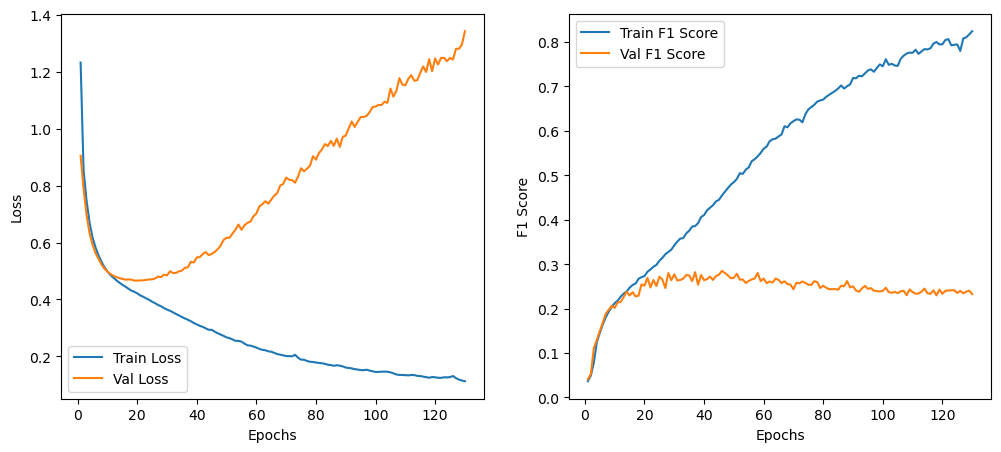

In [14]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()